# Deep Ensemble (Toy)
This example shows how to use deep ensembles with PusH on a toy regression dataset.

In [1]:
# Set a seed for reproducibility
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(0)

# Generate dataset and grid
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x, seed):
    torch.manual_seed(seed)
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values with different seeds
Y = torch.stack([target_toy(x, seed) for x, seed in zip(X, range(X.shape[0]))])

In [2]:
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
        # Additional layers can be added here based on the architecture
        # Apply Xavier uniform initialization to the weights
        self.init_weights(self.net)

    def forward(self, x):
        return self.net(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [3]:
import push.bayes.ensemble
# Combine X and Y into a TensorDataset
dataset = TensorDataset(X, Y)

# Create a DataLoader for batch processing during training
batch_size = 100  # Adjust according to your needs
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


num_ensembles=9
epochs=3000
lr = 0.03


ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        GenericNet, 1,
        lr=lr,
        num_devices=2,
        num_ensembles=num_ensembles,
        bootstrap=False
    )

100%|██████████| 3000/3000 [01:56<00:00, 25.64it/s, loss=tensor(0.0025)]


In [4]:
ensemble_output = ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])

In [5]:
import matplotlib.pyplot as plt
def plot_toy(outputs, num_models, title):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 6])

    # Plot predictive mean and std (left graph)
    axs[0].plot(X, Y, "kx", label="Toy data", markersize=1)
    axs[0].set_xlim(-0.5, 1)
    axs[0].set_ylim(-2, 2)
    axs[0].plot(x_grid, outputs["mean"], "r--", linewidth=1)
    axs[0].fill_between(x_grid.reshape(1, -1)[0], (outputs["mean"] - outputs["std"]).squeeze(), (outputs["mean"] + outputs["std"]).squeeze(), alpha=0.5, color="red")
    axs[0].fill_between(
        x_grid.reshape(1, -1)[0], (outputs["mean"] + 2 * outputs["std"]).squeeze(), (outputs["mean"] - 2 * outputs["std"]).squeeze(), alpha=0.2, color="red"
    )
    axs[0].set_title("Predictive Mean and Std")

    # Plot means of each net in ensemble (right graph)
    axs[1].plot(X, Y, "kx", label="Toy data", markersize=1)
    axs[1].set_xlim(-0.5, 1)
    axs[1].set_ylim(-1.5, 2)
    axs[1].set_title("Individual Model output")

    for j in range(num_models):
        axs[1].plot(x_grid, torch.tensor([sublist[j] for sublist in outputs["pred"]]), linestyle="--", linewidth=1)
    fig.suptitle(title, fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


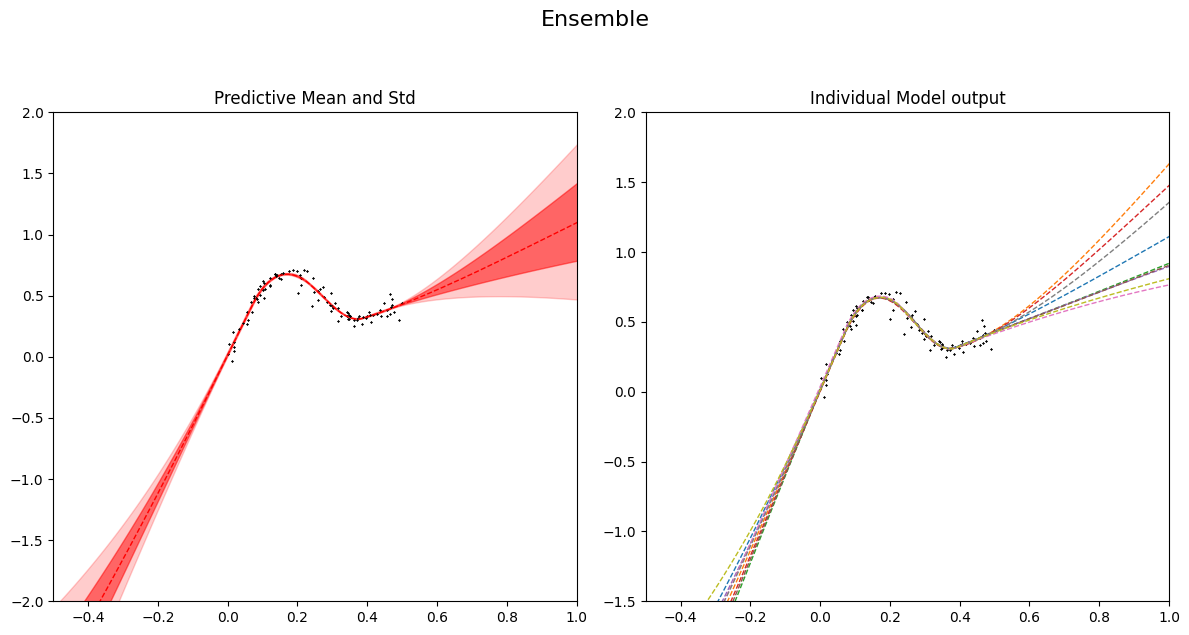

In [6]:
plot_toy(ensemble_output, num_ensembles, "Ensemble")
